In [33]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import least_squares
import sys


# Parameters

In [2]:
A_min = 1e10 # Bq
A_max = 2e10 # Bq
Ab = 500 # Bq
h = 10 # m
dt = 100 # the pause on each point od the grid in s
x_max = 4 # m
y_max = 4 # m
grid = [8, 8] # m
n_bins = 20

radiation = [A_min, A_max, Ab, dt]
detector = [h, x_max, y_max, grid]

## Flyover

In [15]:
def activity(source, x, y, h):
    u, v, A0 = source[0], source[1], source[2]
    return A0 / ((x - u)**2 + (y - v)**2 + h**2)

def point_source(x_max, y_max, A_min, A_max, x_min=0, y_min=0):
    if (x_min == 0) and (y_min == 0):    
        return [random.uniform(-x_max, x_max), random.uniform(-y_max, y_max), random.uniform(A_min, A_max)]
    else:
        return [random.uniform(x_min, x_max), random.uniform(y_min, y_max), random.uniform(A_min, A_max)]

def flyover(radiation, detector, source = []):
    A_min, A_max, Ab, dt = radiation[0], radiation[1], radiation[2], radiation[3]
    h, x_max, y_max, grid = detector[0], detector[1], detector[2], detector[3]
    N_x, N_y = grid[0], grid[1]
    square_x, square_y = (2*x_max)/N_x, (2*y_max)/N_y 
    xs = np.linspace(-x_max + square_x/2, x_max - square_x/2, int(N_x))
    ys = np.linspace(-y_max + square_y/2, y_max - square_y/2, int(N_y))
    if len(source) == 0:
        source = point_source(x_max, y_max, A_min, A_max)
    intensities = np.zeros((int(N_x), int(N_y)))
    grid_x, grid_y = np.meshgrid(xs, ys)
    n, m = N_x - 1, 0
    y = -y_max + square_y/2
    i = 1
    max_intensity = {"number": [0], "postion": [[(0, 0), (0, 0)]]}
    for x in xs:
        while abs(y) <= y_max:
            intensity = activity(source, x, y, h) * dt
            if Ab* dt > intensity:
                intensities[n, m] = 0
            else:
                intensities[n, m] = intensity - Ab*dt
            if max_intensity["number"][0] < intensity:
                max_intensity["number"], max_intensity["position"] = [intensity], [[(x - square_x/2, x + square_x/2), (y - square_y/2, y + square_y/2)]]
            elif max_intensity["number"][0] == intensity:
                max_intensity["position"] = [max_intensity["position"][0], [(x - square_x/2, x + square_x/2), (y - square_y/2, y + square_y/2)]]
            y += (square_y)*i
            n -= 1*i
        n += 1*i
        i = i * (-1)
        y += (square_y)*i
        m += 1

    return {"intensities_array": intensities, "source": source, "grid_x": grid_x, "grid_y": grid_y, "hotspot": max_intensity["position"], "square_x": square_x, "square_y": square_y}

measurement = flyover(radiation, detector)

measurement["hotspot"]


[[(-3.0, -2.0), (3.0, 4.0)]]

## Location from measurement

In [36]:

# Using the Levenberg-Marquardt method with scipy least squares (?)
def locationLM(measurement, radiation, detector):
    A_min, A_max, Ab, dt = radiation[0], radiation[1], radiation[2], radiation[3]
    h = detector[0]
    hotspot = measurement["hotspot"]
    x_min, x_max = hotspot[0][0][0], hotspot[0][0][1]
    y_min, y_max = hotspot[0][1][0], hotspot[0][1][1]
    # def h(theta, x, y):
    #     return theta[2] * (x - theta[0])**2 + theta[3] * (y - theta[1])**2

    # xs = np.linspace(-1, 1, 20)
    # ys = np.linspace(-1, 1, 20)
    gridx, gridy = measurement["grid_x"], measurement["grid_y"]
    # u = 0.1; v = -0.15; A0 = 2 # ; noise = 0.1
    Is = measurement["intensities_array"]
    # hs += noise * np.random.default_rng().random(hs.shape)

    def fun(source):
        return (activity(source, gridx, gridy, h) * dt - Is).flatten()

    source0 = point_source(x_max, y_max, A_min, A_max, x_min, y_min)
    res = least_squares(fun, source0, method="lm")

    return res["x"]

measurement = flyover(radiation, detector)
sourceLM = locationLM(measurement, radiation, detector)

# Using the numpy least squares method
def locationNP(measurement, radiation, detector):
    h = detector[0]
    dt = radiation[3]
    intensities_array, grid_x, grid_y = measurement["intensities_array"], measurement["grid_x"], measurement["grid_y"]
    # print(intensities_array.shape)
    I, J = intensities_array.shape
    x, y, E, D = [], [], [], []
    for i in range(I):
        for j in range(J):
            x.append(grid_x[i, j])
            y.append(grid_y[i, j])
            E.append(-1)
            D.append(dt/intensities_array[i, j])

    M = np.array([np.array(x), np.array(y), np.array(E), np.array(D)]).T
    b = np.array(x)**2 + np.array(y)**2

    c = np.linalg.lstsq(M, b, rcond=None)[0]

    u1 = (1/2)*c[0]
    v1 = (1/2)*c[1]
    u2 = np.sqrt(c[2] - (1/4)*c[1]**2 - h**2)
    v2 = np.sqrt(c[2] - (1/4)*c[0]**2 - h**2)

    # if (np.abs(u1) - np.abs(u2) != 0) or (np.abs(v1) - np.abs(v2) != 0):
    #      sys.exit("The parameters are not in line.")

    return [u1, v1, c[3]]

sourceNP = locationNP(measurement, radiation, detector)

print(sourceNP)


[0.3077392350311855, 0.044333457946777344, 11525637060.073555]


### Useful tutorial 

In [5]:
def h(theta, x, y, h):
    return theta[2] * (x - theta[0])**2 + theta[3] * (y - theta[1])**2 - h

xs = np.linspace(-1, 1, 20)
ys = np.linspace(-1, 1, 20)
dt = 10
gridx, gridy = np.meshgrid(xs, ys)
x0 = 0.1; y0 = -0.15; a = 1; b = 2; noise = 0.1
hs = h([x0, y0, a, b], gridx, gridy, 10) * dt
# hs += noise * np.random.default_rng().random(hs.shape)

def fun(theta):
    return (h(theta, gridx, gridy, 10) * dt - hs).flatten()

theta0 = [0, 0, 1, 2]
res3 = least_squares(fun, theta0)

# print(hs)


## Combine

In [37]:
# combines the detector flyover and the location detection
def combination(radiation, detector, source= []):
    measurement = flyover(radiation, detector, source)
    sourceLM = locationLM(measurement, radiation, detector)
    sourceNP = locationNP(measurement, radiation, detector)
    return {'measurement': measurement, 'source_locationLM': sourceLM, 'source_locationNP': sourceNP}


## Visualization

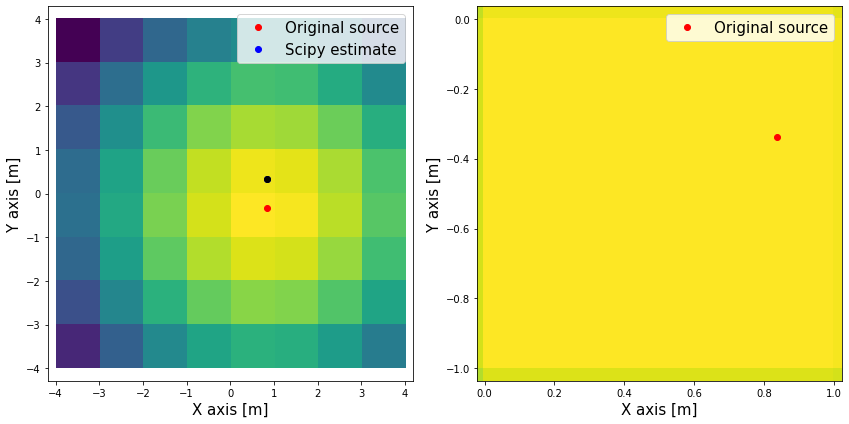

In [48]:
def visualize(measurement, x_max, y_max, points):
    u1, v1 = points[0][0], points[0][1]
    u2, v2 = points[1][0], points[1][1]

    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
    
    im = ax1.imshow(measurement["intensities_array"], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    # plt.imshow(np.zeros((8, 8)), extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    X, Y = measurement["source"][0], measurement["source"][1]
    ax1.plot(X, Y, "o", color = 'r', label = "Original source")
    ax1.plot(u1, v1, "o", color = 'b', label = "Scipy estimate")
    # ax1.plot(u2, v2, "o", color = 'k', label = "Numpy estimate")

    ax1.axis("equal")
    ax1.set_xlabel("X axis [m]", fontsize = 15)
    ax1.set_ylabel("Y axis [m]", fontsize = 15)
   
    ax1.legend(fontsize = 15)

    ax2.imshow(measurement["intensities_array"], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    # plt.imshow(np.zeros((8, 8)), extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    X, Y = measurement["source"][0], measurement["source"][1]
    ax2.plot(X, Y, "o", color = 'r', label = "Original source")
    # ax2.plot(points["point_candidates"][:, 0], points["point_candidates"][:, 1], "o", color = 'g', label = "Estimated sources")
    # ax1.plot(u1, v1, "o", color = 'b', label = "Scipy estimate")
    ax1.plot(u2, v2, "o", color = 'k', label = "Numpy estimate")
    ax2.axis("equal")
    ax2.set_xlim(measurement["hotspot"][0][0][0], measurement["hotspot"][0][0][1])
    ax2.set_xlabel("X axis [m]", fontsize = 15)
    ax2.set_ylim(measurement["hotspot"][0][1][0], measurement["hotspot"][0][1][1])
    ax2.set_ylabel("Y axis [m]", fontsize = 15)

   
    ax2.legend(fontsize = 15)    

    plt.tight_layout()
    # plt.savefig("graphics/imporved.jpg")
    plt.show()
    # return points[1]


data = combination(radiation, detector)

visualize(data["measurement"], detector[1], detector[2], [data["source_locationLM"], data["source_locationNP"]])
